In [16]:
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from IPython.display import display

import importlib
import glob
import time
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString
import osmnx as ox
from src.data import processing_func
import boto3

pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

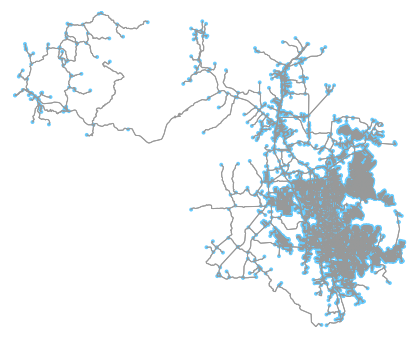

,highway,osmid,ref,x,y,geometry
1781596160,NaN,1781596160,NaN,-48.808,-26.3669,POINT (-48.8079739 -26.3668993)
1781596162,NaN,1781596162,NaN,-48.8084,-26.3622,POINT (-48.8083837 -26.3621753)
1781596166,NaN,1781596166,NaN,-48.8078,-26.3637,POINT (-48.8077687 -26.3636905)
1781596168,NaN,1781596168,NaN,-48.8088,-26.3682,POINT (-48.808759 -26.3682434)
1781596170,NaN,1781596170,NaN,-48.8077,-26.3622,POINT (-48.8076757 -26.3622238)


,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80799...",residential,NaN,0,NaN,32.577,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,2712030379,NaN
1,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80787...",residential,NaN,0,NaN,165.663,NaN,Rua Mato Grosso do Sul,False,166708221,NaN,NaN,NaN,1781596160,1781596141,NaN
2,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80763...",residential,NaN,0,NaN,34.044,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,4331763612,NaN
3,NaN,NaN,"LINESTRING (-48.8079739 -26.3668993, -48.80867...",residential,NaN,0,NaN,69.976,NaN,Rua Vilmar da Silva,False,166708230,NaN,NaN,NaN,1781596160,1808444244,NaN
4,NaN,NaN,"LINESTRING (-48.8083837 -26.3621753, -48.80847...",residential,NaN,0,NaN,163.247,NaN,Rua Espírito Santo,False,166708219,NaN,NaN,NaN,1781596162,1808444235,NaN


In [48]:
#Create Joinville polygon
joinville_polygon = "-48.802 -26.13,-48.883 -26.107,-49.161 -26.059,-49.224 -26.103,-49.239 -26.178,-49.245 -26.306,-49.043 -26.358,-48.923 -26.41,-48.898 -26.444,-48.858 -26.438,-48.802 -26.395,-48.727 -26.354,-48.746 -26.285,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13,-48.802 -26.13"
joinville_polygon = joinville_polygon.split(",")
joinville_polygon = [(float(coord.split(" ")[0]), float(coord.split(" ")[1])) for coord in joinville_polygon]
joinville_polygon = Polygon(joinville_polygon)

#Retrieve osm data from polygon
G = ox.graph_from_polygon(joinville_polygon, network_type='drive')
ox.plot_graph(G)

gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
display(gdf_nodes.head())
display(gdf_edges.head())

In [3]:
print("Types of highway:")
gdf_edges.highway.apply(pd.Series).fillna("Guilherme")[0].value_counts()

Types of highway:


residential       23410
tertiary           3856
primary            2103
secondary          1819
unclassified        865
primary_link        163
living_street       123
motorway             96
motorway_link        84
secondary_link       54
tertiary_link        39
dummy                 2
Name: 0, dtype: int64

In [4]:
def split_df_list(gdf,target_column):
    """ df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    crs = gdf.crs
    row_accumulator = []
    
    def split_list_to_rows(row):
        split_row = row[target_column] if type(row[target_column]) is list else [row[target_column]] 
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)    

    for index, row in gdf.iterrows():
        split_list_to_rows(row)
        
    new_df = pd.DataFrame(row_accumulator)
    new_gdf = gpd.GeoDataFrame(new_df, crs=crs)
    return new_gdf

def filter_primary(df, class_list):
    filtered_df = df.loc[df.highway.isin(class_list)]
    return filtered_df

major_gdf_edges = (gdf_edges
                   .pipe(split_df_list, target_column="highway")
                   .pipe(filter_primary, class_list=["primary", "secondary", "tertiary", "motorway"])
                   .reset_index()
                   .drop_duplicates(subset="index")
                   .drop("index", axis=1)
                   .reset_index(drop=True)
                  )
  
display(major_gdf_edges.shape)
display(major_gdf_edges.sample(5))  

(7890, 18)

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
5450,NaN,NaN,"LINESTRING (-48.816408 -26.2936937, -48.816996...",primary,NaN,0,2,83.682,60,Rua Prefeito Helmuth Fallgatter,True,264249156,NaN,NaN,NaN,1346098096,1346097945,NaN
3983,NaN,NaN,"LINESTRING (-48.8594739 -26.2663669, -48.85929...",primary,NaN,0,NaN,26.837,NaN,Rua Dona Francisca,False,255630299,NaN,NaN,NaN,1148206605,3687464057,NaN
1261,NaN,NaN,"LINESTRING (-48.8139136 -26.3433249, -48.81394...",tertiary,NaN,0,2,100.788,40,Rua Kesser Zattar,False,265353827,NaN,NaN,NaN,2624984684,1820783925,NaN
4879,NaN,NaN,"LINESTRING (-48.803668 -26.338474, -48.8034711...",primary,NaN,0,2,108.023,NaN,Rua Monsenhor Gercino,False,264419354,NaN,NaN,NaN,2627587494,2627587502,NaN
6957,NaN,yes,"LINESTRING (-48.8003514 -26.2717034, -48.80013...",tertiary,NaN,0,2,67.853,NaN,Rua Ponte Serrada,False,"[359361266, 359361267, 270268975]",NaN,NaN,NaN,1245987659,1270297390,NaN


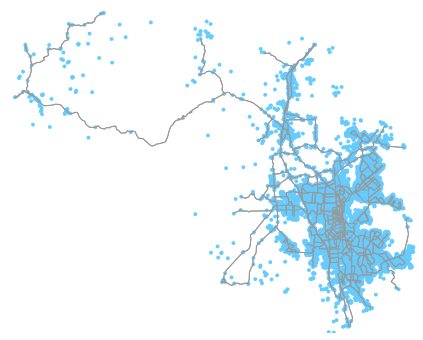

(<Figure size 604.165x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbc14994278>)

In [30]:
major_traffic_network = ox.save_load.gdfs_to_graph(gdf_nodes=gdf_nodes, gdf_edges=major_gdf_edges)
ox.plot_graph(major_traffic_network)

Get Waze data:

In [13]:
#Connection and initial setup
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

importlib.reload(processing_func)
meta = processing_func.connect_database(DATABASE)

date_begin = datetime.date(day=17, month=3, year=2018)
date_end = datetime.date(day=20, month=6, year=2018)
periods = None
weekends = False

importlib.reload(processing_func)
df_jams = processing_func.extract_df_jams(meta, date_begin, date_end, weekends=weekends)
geo_jams = processing_func.transform_geo_jams(df_jams)
display(geo_jams.shape)
display(geo_jams.head())

(182628, 17)

,start_time,uuid,level,length,speed_kmh,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring
0,2018-06-19 10:07:00-03:00,1731291032,3,262,7.32,80,"[{'x': -48.845409, 'y': -26.313003}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.845409, -26.313003), (-48.844696, -26.31...",LINESTRING (715082.8056279121 7087859.11776230...
1,2018-06-19 10:07:00-03:00,1731524604,2,218,3.11,143,"[{'x': -48.851244, 'y': -26.282342}, {'x': -48...",West,South,North/South,2018-06-19,13,7,1,0 a 14,"[(-48.851244, -26.282342), (-48.851246, -26.28...",LINESTRING (714556.6276389689 7091265.93479170...
2,2018-06-19 10:07:00-03:00,1172826925,5,103,0.00,-1,"[{'x': -48.84207, 'y': -26.30179}, {'x': -48.8...",West,South,North/South,2018-06-19,13,7,1,0 a 14,"[(-48.84207, -26.30179), (-48.842098, -26.3027...",LINESTRING (715436.9658536196 7089095.91357134...
3,2018-06-19 10:07:00-03:00,1711463041,3,681,10.48,150,"[{'x': -48.857303, 'y': -26.302854}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.857303, -26.302854), (-48.856287, -26.30...",LINESTRING (713913.7895324535 7089003.33620043...
4,2018-06-19 10:07:00-03:00,1711463841,4,197,3.03,201,"[{'x': -48.852236, 'y': -26.28241}, {'x': -48....",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.852236, -26.28241), (-48.851244, -26.282...",LINESTRING (714457.4213734203 7091260.04643778...


Merge Waze jams and OSM

In [24]:
importlib.reload(processing_func)
allocated_jams = allocate_jams(geo_jams, major_gdf_edges, small_buffer=10, big_buffer=20, network_directional=True)
display(allocated_jams.shape)
display(allocated_jams.head())

(1244705, 38)

,start_time,uuid,level,length_jams,speed_kmh,delay,line,LonDirection,LatDirection,MajorDirection,date,hour,minute,period,minute_bin,jams_line_list,linestring,direction_jams,index_net,access,bridge,geometry,highway,junction,key,lanes,length_net,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width,direction_net
0,2018-06-19 10:07:00-03:00,1172826925,5,103,0.00,-1,"[{'x': -48.84207, 'y': -26.30179}, {'x': -48.8...",West,South,North/South,2018-06-19,13,7,1,0 a 14,"[(-48.84207, -26.30179), (-48.842098, -26.3027...",LINESTRING (715436.9658536196 7089095.91357134...,Sul,3338.0,NaN,NaN,LINESTRING (715433.6564772686 7089096.33455565...,secondary,NaN,0.0,NaN,104.002,40,Rua Itajaí,True,264242507,NaN,NaN,NaN,1.111373e+09,1.111756e+09,NaN,Sul
1,2018-06-19 10:07:00-03:00,1711463041,3,681,10.48,150,"[{'x': -48.857303, 'y': -26.302854}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.857303, -26.302854), (-48.856287, -26.30...",LINESTRING (713913.7895324535 7089003.33620043...,Leste,5045.0,NaN,NaN,LINESTRING (714171.9784984927 7089074.55906564...,secondary,NaN,0.0,2,112.638,NaN,Rua Otto Boehm,False,263923344,NaN,NaN,NaN,1.344885e+09,1.111373e+09,NaN,Leste
2,2018-06-19 10:07:00-03:00,1711463041,3,681,10.48,150,"[{'x': -48.857303, 'y': -26.302854}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.857303, -26.302854), (-48.856287, -26.30...",LINESTRING (713913.7895324535 7089003.33620043...,Leste,3357.0,NaN,NaN,LINESTRING (714279.2314831616 7089109.47299390...,secondary,NaN,0.0,2,112.638,NaN,Rua Otto Boehm,False,263923344,NaN,NaN,NaN,1.111373e+09,1.344885e+09,NaN,Oeste
3,2018-06-19 10:07:00-03:00,1711463041,3,681,10.48,150,"[{'x': -48.857303, 'y': -26.302854}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.857303, -26.302854), (-48.856287, -26.30...",LINESTRING (713913.7895324535 7089003.33620043...,Leste,3356.0,NaN,NaN,LINESTRING (714279.2314831616 7089109.47299390...,secondary,NaN,0.0,2,150.053,NaN,Rua Otto Boehm,False,259491068,NaN,NaN,NaN,1.111373e+09,1.111373e+09,NaN,Leste
4,2018-06-19 10:07:00-03:00,1711463041,3,681,10.48,150,"[{'x': -48.857303, 'y': -26.302854}, {'x': -48...",East,North,East/West,2018-06-19,13,7,1,0 a 14,"[(-48.857303, -26.302854), (-48.856287, -26.30...",LINESTRING (713913.7895324535 7089003.33620043...,Leste,3393.0,NaN,NaN,LINESTRING (714422.4609348555 7089154.90418796...,secondary,NaN,0.0,2,150.053,NaN,Rua Otto Boehm,False,259491068,NaN,NaN,NaN,1.111373e+09,1.111373e+09,NaN,Oeste


### Get back to 7890 edges - figure out way of consolidating traffic indicators

Clean unused nodes and create graph with Waze data as attributes:

(13027, 6)

(4462, 6)

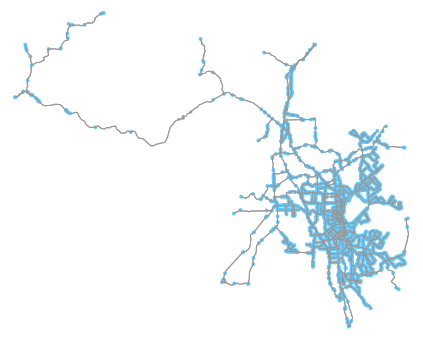

(<Figure size 604.165x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbc06c95cc0>)

In [45]:
display(gdf_nodes.shape)
major_gdf_nodes = gdf_nodes[gdf_nodes.index.to_series().isin(major_gdf_edges.u) |
                              gdf_nodes.index.to_series().isin(major_gdf_edges.v)]
major_gdf_nodes.gdf_name = gdf_nodes.gdf_name
display(major_gdf_nodes.shape)

major_traffic_network = ox.save_load.gdfs_to_graph(gdf_nodes=major_gdf_nodes, gdf_edges=major_gdf_edges)
ox.plot_graph(major_traffic_network)

In [2]:
folder = project_dir + "/data/interim"
ox.save_load.save_graph_shapefile(major_traffic_network, filename="major_traffic_network", folder=folder)
s3.put_object(Body=major_traffic_network.read(), Bucket='smartmob-data', Key=file_name)

NameError: name 'ox' is not defined

In [ ]:
folder_name = "processed/SHP_for_netconvert"
file_name = folder_name + "major_traffic_network"
ox.save_load.save_graph_shapefile(major_traffic_network, filename="major_traffic_network", folder=folder_name)
s3.put_object(Body=stream.read(), Bucket='smartmob-data', Key=file_name)

Save as shapefile in data/interim to be used by SUMO: